In [21]:
import GPy
import pandas as pd 
import numpy as np 
import os
import sys 
sys.path.append('../')
from dispersant_screener.definitions import FEATURES
DATADIR = '../data'

from dispersant_screener.pal import pal
from dispersant_screener.definitions import FEATURES
from dispersant_screener.utils import get_maxmin_samples, get_kmeans_samples 
from dispersant_screener.gp import build_model, build_coregionalized_model

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt 
%matplotlib inline

from dispersant_screener.utils import is_pareto_efficient, is_pareto_efficient_reordered

Implement and test the discarding step.

In [63]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values  * (-1)
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max =  pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([rg.reshape(-1,1), gibbs.reshape(-1,1)])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [83]:
%%time
pareto_mask = is_pareto_efficient(-y)

CPU times: user 46.4 ms, sys: 4.43 ms, total: 50.8 ms
Wall time: 81.3 ms


In [107]:
y_new = np.vstack([y, np.array([2, 2.2])])

In [109]:
pareto_mask_new = is_pareto_efficient(-y_new)

In [84]:
pareto_set = y[pareto_mask]

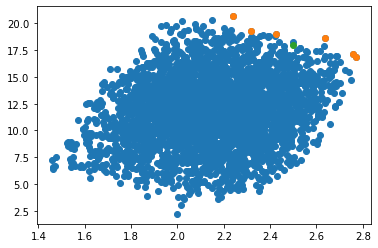

In [172]:
plt.scatter(y_new[:,0], y_new[:,1])
plt.scatter(y_new[pareto_mask_new,0], y_new[pareto_mask_new,1])
plt.scatter(2.5, 18)

In [93]:
pareto_set

array([[ 2.23864917, 20.67349609],
       [ 2.31628703, 19.25144458],
       [ 2.42618167, 18.97836707],
       [ 2.6353925 , 18.64838044],
       [ 2.75846519, 17.12920947],
       [ 2.77117031, 16.8951498 ]])

In [166]:
def dominance_check(p1, p2): 
    if np.all(p1>=p2) and np.any(p1>p2):
        return True

    return False

In [167]:
from numpy import vectorize

In [168]:
vec_dom = vectorize(dominance_check)

In [176]:
np.all(vec_dom(np.array([2.5,20]), pareto_set), axis=1)

array([False,  True,  True, False, False, False])

In [222]:
vec_dom(pareto_set, np.array([2.5, 2.5]))

array([[False,  True],
       [False,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [219]:
pareto_set

array([[ 2.23864917, 20.67349609],
       [ 2.31628703, 19.25144458],
       [ 2.42618167, 18.97836707],
       [ 2.6353925 , 18.64838044],
       [ 2.75846519, 17.12920947],
       [ 2.77117031, 16.8951498 ]])

In [171]:
for point in pareto_set:
    if dominance_check(np.array([2.5, 18]), point):
        print('Dominant')

In [177]:
np.any(np.all(vec_dom(pareto_set, np.array([2.5,20])), axis=1))

False

In [38]:
pareto_set

array([[ 2.23864917, 20.67349609],
       [ 2.31628703, 19.25144458],
       [ 2.42618167, 18.97836707],
       [ 2.6353925 , 18.64838044],
       [ 2.75846519, 17.12920947],
       [ 2.77117031, 16.8951498 ]])

In [30]:
pareto_set.max(axis=0)

array([ 2.77117031, 20.67349609])

In [208]:
a

array([[  2.23864917,  20.67349609],
       [  2.31628703,  19.25144458],
       [  2.42618167,  18.97836707],
       [  2.6353925 ,  18.64838044],
       [  2.75846519,  17.12920947],
       [  2.77117031,  16.8951498 ],
       [  1.        ,   1.        ],
       [-20.        ,  20.        ],
       [  1.        ,   1.        ]])

In [194]:
a_masked = np.ma.array(a)

In [195]:
a_masked

masked_array(
  data=[[  2.23864917,  20.67349609],
        [  2.31628703,  19.25144458],
        [  2.42618167,  18.97836707],
        [  2.6353925 ,  18.64838044],
        [  2.75846519,  17.12920947],
        [  2.77117031,  16.8951498 ],
        [  1.        ,   1.        ],
        [-20.        ,  20.        ],
        [  1.        ,   1.        ]],
  mask=False,
  fill_value=1e+20)

In [213]:
a_masked[-1] = np.ma.masked

In [214]:
np.where((a_masked-np.array([1,1])).sum(axis=-1)==0)

(array([6]),)

In [215]:
a_masked.mask = np.ma.nomask

In [216]:
a_masked

masked_array(
  data=[[2.2386491704147926, 20.673496088888907],
        [2.3162870314842583, 19.251444577777786],
        [2.4261816741629185, 18.97836706666666],
        [2.635392503748126, 18.648380444444452],
        [2.7584651874062973, 17.129209466666673],
        [2.7711703148425784, 16.89514980000001],
        [1.0, 1.0],
        [-20.0, 20.0],
        [1.0, 1.0]],
  mask=[[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],
  fill_value=1e+20)

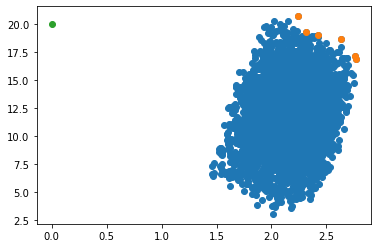

In [40]:
plt.scatter(y[:,0], y[:,1])
plt.scatter(y[pareto_mask,0], y[pareto_mask,1])
plt.scatter(0, 20)

Maybe add all of our points to the set and then see which ones are False?

In [55]:
query = np.array([[0,0], [-20,20], [2.23864917, 20.87349609]]) 

In [58]:
a = np.vstack([pareto_set, query])

In [61]:
mask_a = is_pareto_efficient(-a)

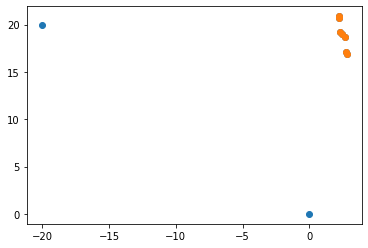

In [62]:
plt.scatter(a[:,0], a[:,1])
plt.scatter(a[mask_a,0], a[mask_a,1])

algorithm to implement tomorrow

(1) run is_pareto_efficient on the lower bounds 

(2) the run for each point in the unclassified ones np.any(np.all(np.array([upper*(1+epsilon)])>pareto_set, axis=0)) and discard if the point is still under the Pareto pessimistic 


In [53]:
pareto_indices = np.where(pareto_optimal_0==1)[0]

pareto_pessimistic_lows = rectangle_lows[pareto_indices]

for i in range(0, len(x_input)):
    if unclassified_t[i] == 1:
        if not np.any(np.all(np.array([rectangle_up[i]*(1+epsilon)])>pareto_set, axis=0)):
            not_pareto_optimal_t[i] = 1
            unclassified_t[i] = 0
                     

NameError: name 'pareto_optimal_0' is not defined

In [ ]:
if not np.any(np.all(rectangle_ups >= rectangle_lows[i] * (1 + epsilon), axis=0)):